# Juillet 2021

## Pre-processing commun

In [ ]:
require(tidyverse)
require(caret)
require(data.table)
require(xgboost)
require(stringr)
require(psych)
require(lubridate)
require(data.table) ;

In [1]:
dl <- tempfile()
download.file("http://files.grouplens.org/datasets/movielens/ml-10m.zip", dl)

In [2]:
ratings <- fread(text = gsub("::", "\t", readLines(unzip(dl, "ml-10M100K/ratings.dat"))),
                 col.names = c("userId", "movieId", "rating", "timestamp"))

movies <- str_split_fixed(readLines(unzip(dl, "ml-10M100K/movies.dat")), "\\::", 3)

colnames(movies) <- c("movieId", "title", "genres")

In [3]:
# Pour R 4.0 ou plus récent:
movies <- as.data.frame(movies) %>% mutate(movieId = as.numeric(movieId),
                                           title = as.character(title),
                                           genres = as.character(genres))


movielens <- left_join(ratings, movies, by = "movieId")

In [4]:
# Le set de validation comporte 10% du dataset, avec seed fixe obligatoire.
set.seed(1, sample.kind="Rounding") 
test_index <- createDataPartition (y = movielens$rating, times = 1, p = 0.1, list = FALSE)
edx <- movielens[-test_index,]
temp <- movielens[test_index,] ;

Warning message in set.seed(1, sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"


In [5]:
#Il faut s'assurer que les ID des films et des utilisateurs du set de validation soient dans le set de training.

validation <- temp %>% 
  semi_join(edx, by = "movieId") %>%
  semi_join(edx, by = "userId")

removed <- anti_join(temp, validation)
edx <- rbind(edx, removed)

Joining, by = c("userId", "movieId", "rating", "timestamp", "title", "genres")



In [6]:
#Suppression des objets devenus inutiles
rm(dl, ratings, movies, test_index, temp, movielens, removed) ;

# Partie 2 : Data Visualisation

In [7]:
edx

userId,movieId,rating,timestamp,title,genres
<int>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,122,5,838985046,Boomerang (1992),Comedy|Romance
1,185,5,838983525,"Net, The (1995)",Action|Crime|Thriller
1,292,5,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller
1,316,5,838983392,Stargate (1994),Action|Adventure|Sci-Fi
1,329,5,838983392,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi
1,355,5,838984474,"Flintstones, The (1994)",Children|Comedy|Fantasy
1,356,5,838983653,Forrest Gump (1994),Comedy|Drama|Romance|War
1,362,5,838984885,"Jungle Book, The (1994)",Adventure|Children|Romance
1,364,5,838983707,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical


In [8]:
length(edx$rating)
length(unique(edx$userId))
length(unique(edx$movieId))

[1] 9000055

[1] 69878

[1] 10677

##### Pour ces quelques 9 Millions de notes, elles concernent 10677 films uniques et 69 878 utilisateurs uniques.

## Répartition des notes

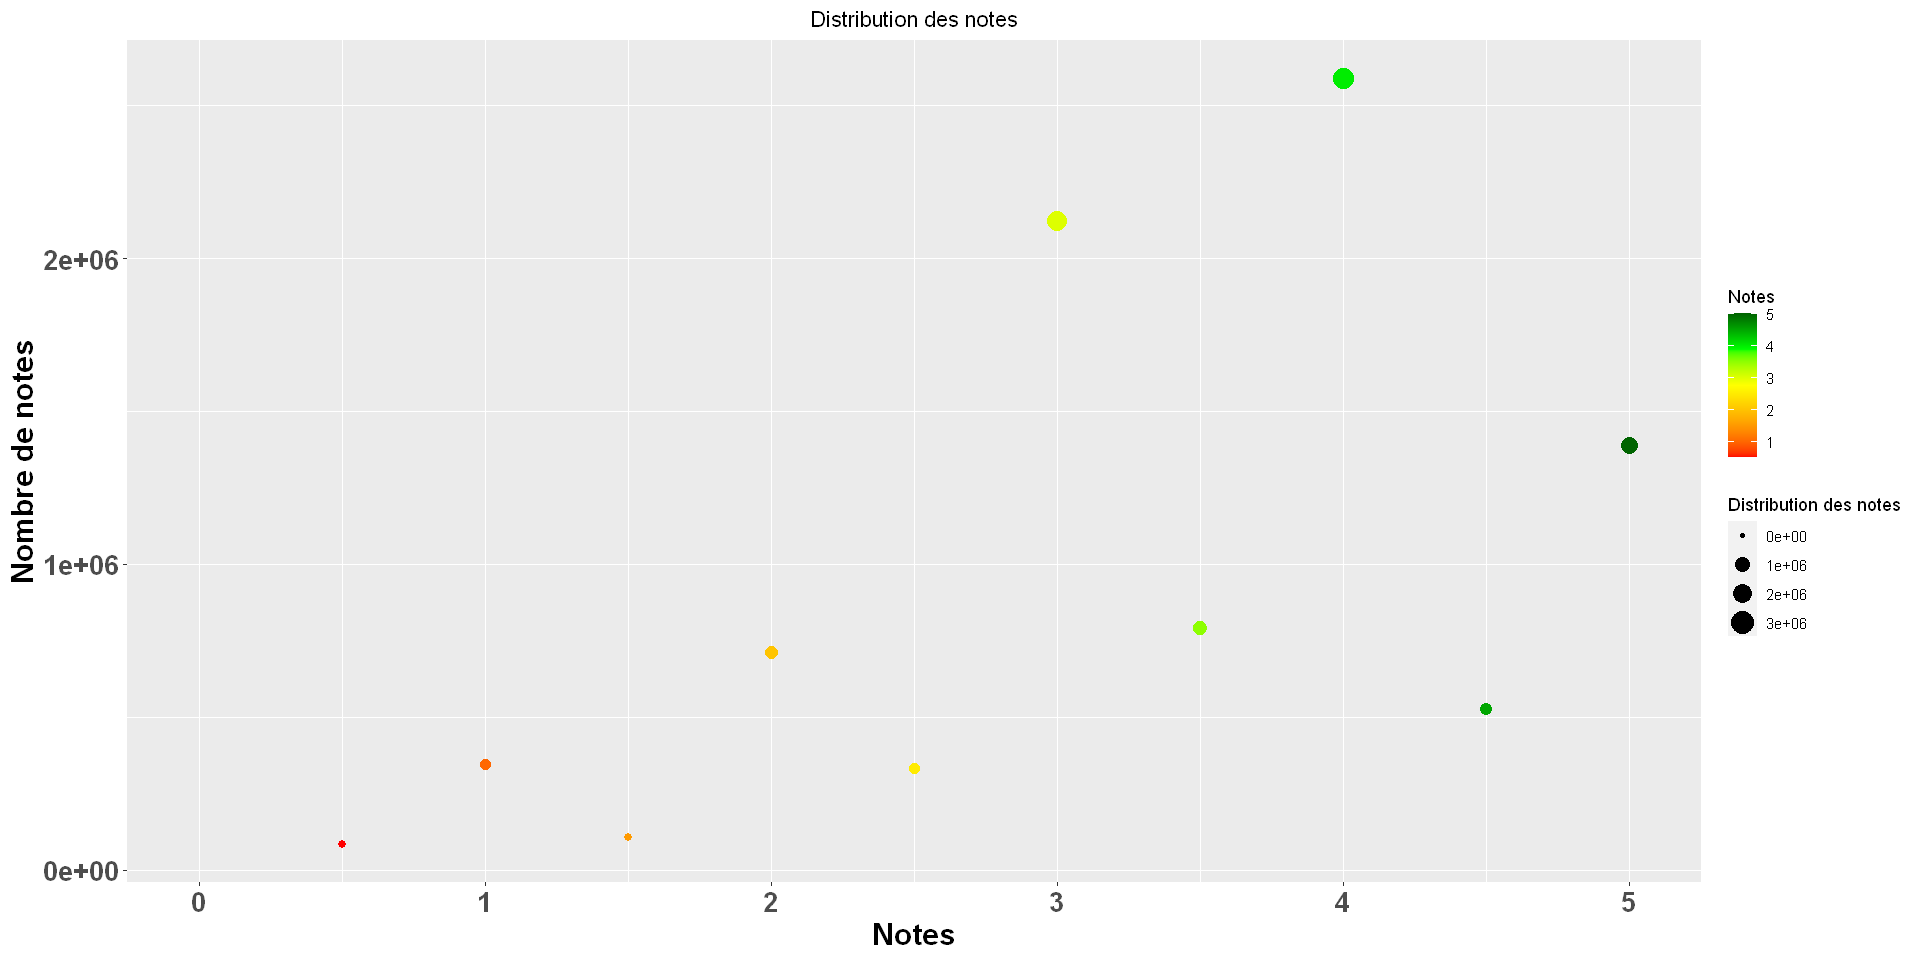

In [9]:
notes <- edx %>% 
  group_by(rating) %>% 
  summarize(num_ratings = n()) %>% 
  arrange(desc(num_ratings)) # 
options(repr.plot.width=16, repr.plot.height=8)
h <- notes %>%
  ggplot(aes(rating, num_ratings, color = rating)) +
  geom_point(aes(size = num_ratings)) +
  scale_color_gradientn(colours = c("red", "orange","yellow","green","darkgreen")) +
  scale_size_continuous(limits = c(0, 3e+06)) +
  xlim(0,5) +
  theme(plot.title = element_text(hjust = 0.5))+
  labs(x = "Notes", y = "Nombre de notes", title = "Distribution des notes", color = "Notes", size = "Distribution des notes")

h + theme(axis.text=element_text(size=16, face='bold'),
        axis.title=element_text(size=18,face="bold"))

##### On observe un comportement récurent ; les notes arrondies sont largement majoritaires par rapport aux notes décimales.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



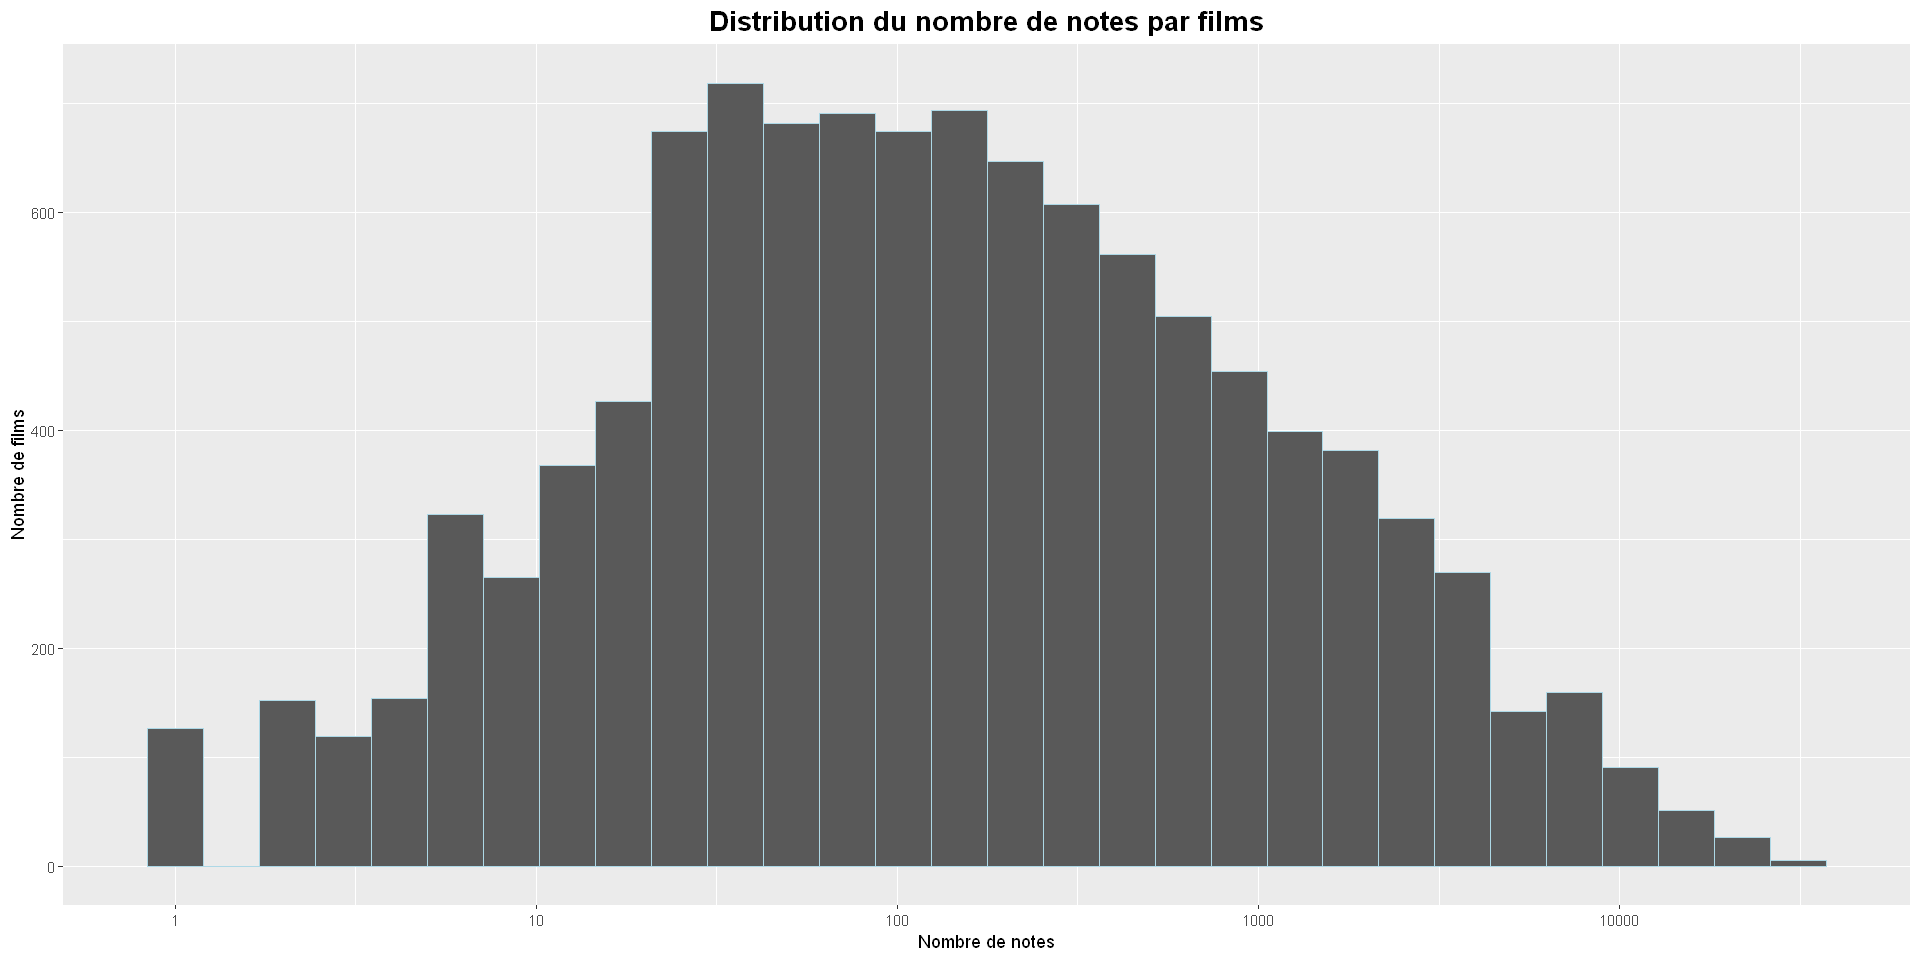

In [10]:
edx %>% group_by(movieId) %>%
  summarise(n=n()) %>%
  ggplot(aes(n)) +
    geom_histogram(color = "lightblue") +
    scale_x_log10() + 
    ggtitle("Distribution du nombre de notes par films") +
    theme(plot.title = element_text(hjust = 0.5,size=16, face='bold'))+
    xlab("Nombre de notes") +
    ylab("Nombre de films")

###### Un nombre non-négligeable de films ont moins de 10 notes, la grande majorité en ont entre 10 et 1000. Certains blockbusters dépassent 30000 notes reçues.

##### Si on s'interesse au top 10 des films les plus populaires en terme de notes reçues ;

In [11]:
topfilm <- edx %>% group_by(movieId) %>%
  summarise(n=n())

topfilm <- as.data.frame(topfilm)
topfilm <- topfilm[order(-topfilm$n),]
top10 <- topfilm$movieId[1:10]

for (i in 1:length(top10)){
  result <- filter(edx, movieId == top10[i])
  print(result$title[1])
}

[1] "Pulp Fiction (1994)"
[1] "Forrest Gump (1994)"
[1] "Silence of the Lambs, The (1991)"
[1] "Jurassic Park (1993)"
[1] "Shawshank Redemption, The (1994)"
[1] "Braveheart (1995)"
[1] "Fugitive, The (1993)"
[1] "Terminator 2: Judgment Day (1991)"
[1] "Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977)"
[1] "Apollo 13 (1995)"


### Popularité des Genres

In [12]:
graph_genre <- edx %>%
  separate_rows(genres, sep = "\\|")

graph_genre2 <- graph_genre %>%
  group_by(genres) %>%
  summarize(num_ratings = n(), avg_rating = mean(rating)) %>%
  arrange(desc(num_ratings))

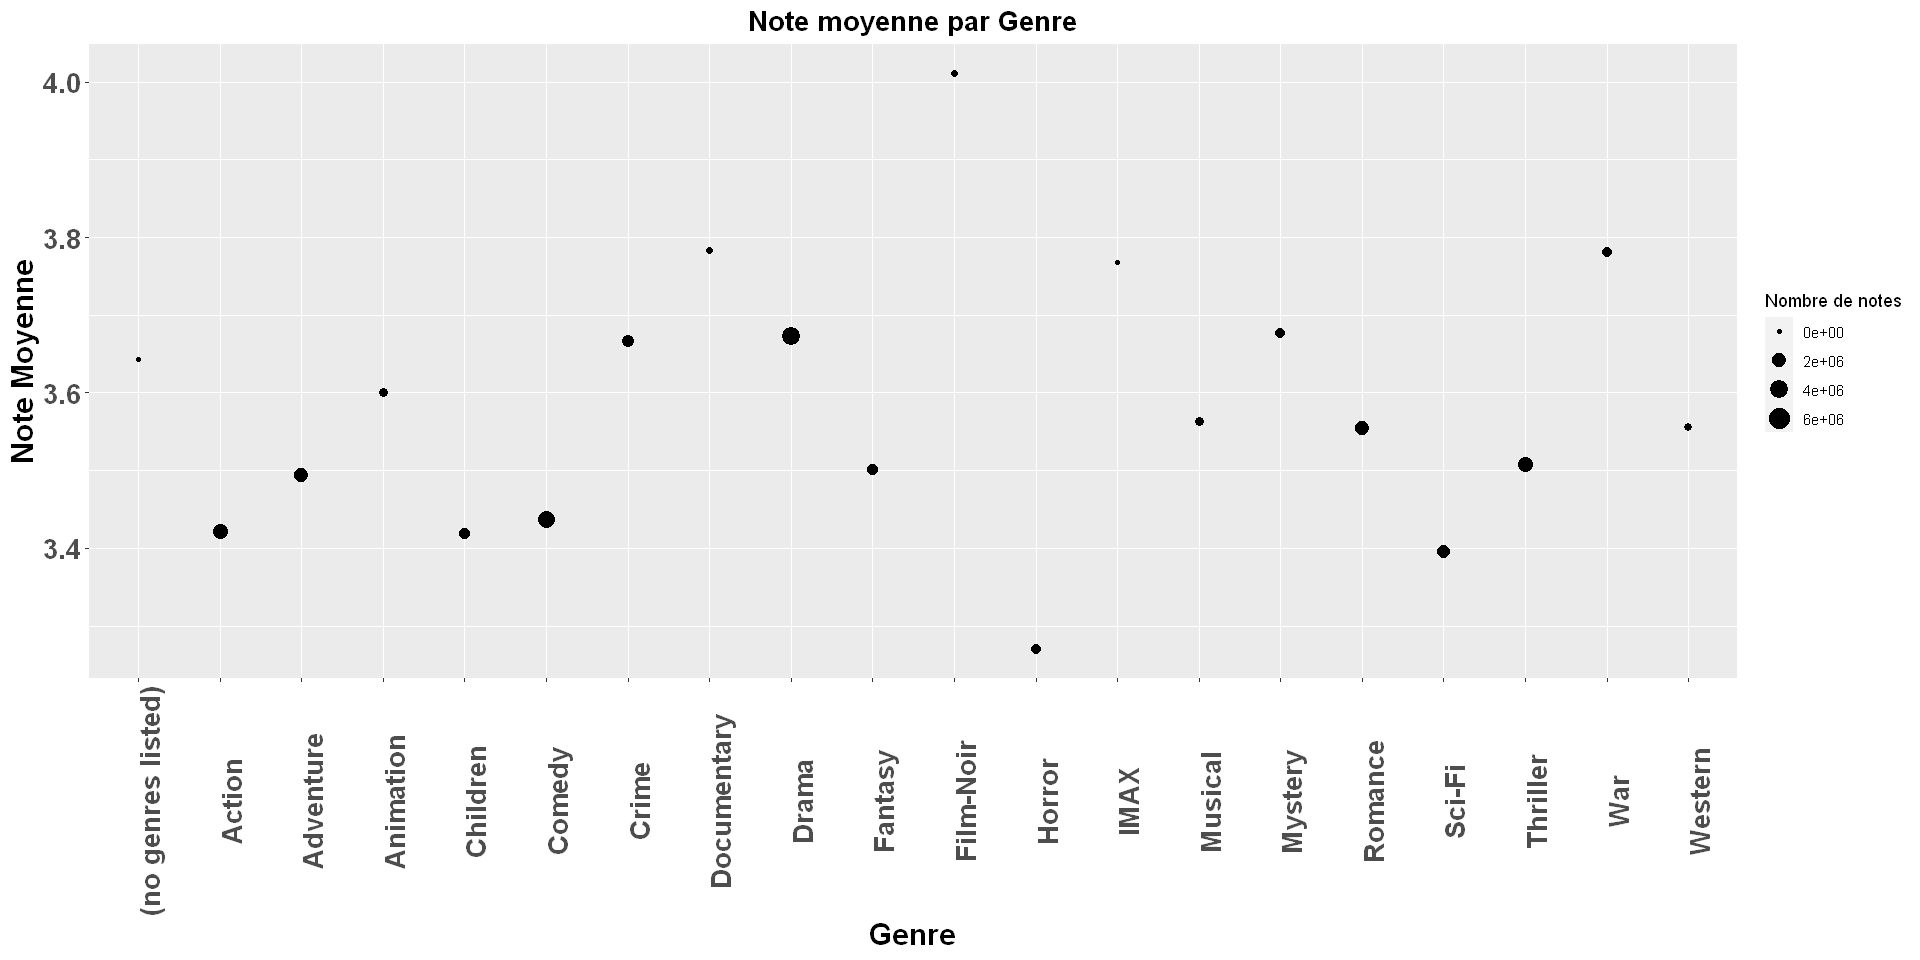

In [13]:
p <- graph_genre2 %>%
  ggplot(aes(genres, avg_rating)) +
  geom_point(aes(size = num_ratings)) +
  scale_size_continuous(limits = c(0, 7e+06)) +
  theme(plot.title = element_text(hjust = 0.5, size=16, face='bold'))+
  labs(x = "Genre", y = "Note Moyenne", title = "Note moyenne par Genre", size = "Nombre de notes") +
  theme(axis.text.x = element_text(angle = 90))

p + theme(axis.text=element_text(size=16, face='bold'),
        axis.title=element_text(size=18,face="bold"))

##### Les films d'horreurs sont les moins populaires, le genre Film-Noir est le plus populaire mais est un des genres ayant reçu le moins de notes.
##### Le détail est visible ci-dessous.

In [14]:
graph_genre2

genres,num_ratings,avg_rating
<chr>,<int>,<dbl>
Drama,3910127,3.673131
Comedy,3540930,3.436908
Action,2560545,3.421405
Thriller,2325899,3.507676
Adventure,1908892,3.493544
Romance,1712100,3.553813
Sci-Fi,1341183,3.395743
Crime,1327715,3.665925
Fantasy,925637,3.501946


### L'effet de l'ancienneté

In [15]:
graph_year <- edx %>%
  mutate(year = substring(title, nchar(title) - 6)) %>% 
  mutate(year = as.numeric(substring(year, regexpr("\\(", year) + 1, regexpr("\\)", year) - 1))) 

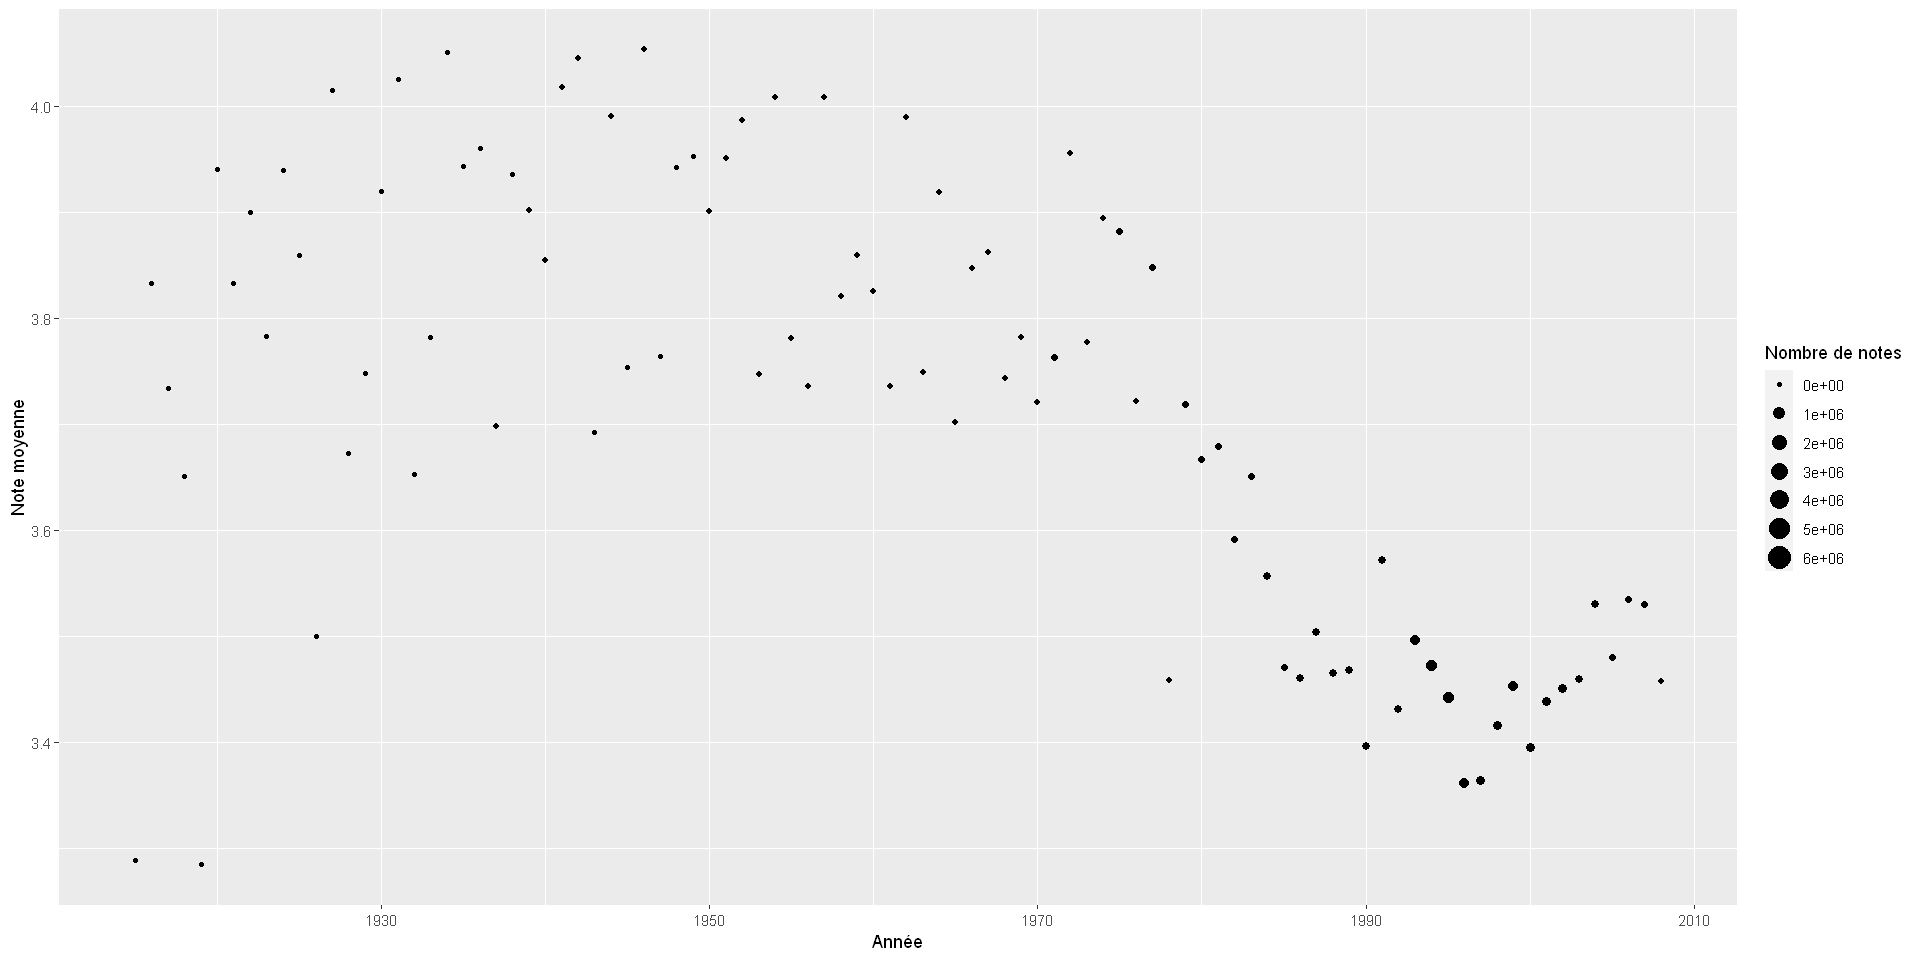

In [16]:
graph_year2 <- graph_year %>%
  group_by(year) %>% 
  summarize(num_ratings = n(), avg_rating = mean(rating)) %>% 
  arrange(desc(num_ratings))

graph_year2 %>%
  ggplot(aes(year, avg_rating, size = num_ratings)) +
  geom_point(aes(size = num_ratings)) +
  scale_size_continuous(limits = c(0, 6e+06)) +
  labs(x = "Année", y = "Note moyenne", size = "Nombre de notes")

##### Si les films les plus récents ont très clairement reçus beaucoup plus de notes, on observe assez nettement une meilleure moyenne pour les films plus anciens.

# Partie 3 : Modèle prédictif
### L'objectif est d'obtenir un Root Mean Square Error le plus bas possible sur le set de validation.
##### Le barème lié au RMSE est le suivant; 

##### 0 points: Aucun RMSE / abandon
##### 5 points: RMSE >= 0.90000 ou erreur de manipulation ayant entraîné l'entrainement du modèle sur set de validation.
##### 10 points: 0.86550 <= RMSE <= 0.89999
##### 15 points: 0.86500 <= RMSE <= 0.86549
##### 20 points: 0.86490 <= RMSE <= 0.86499
##### 25 points: RMSE < 0.86490

In [17]:
require(recosystem) ;

In [25]:
training <- edx %>% select(movieId, userId, rating)
validation <- validation %>% select(movieId, userId, rating)

training <- as.matrix(training)
validation <- as.matrix(validation)

In [18]:
head(training)
head(validation)

movieId,userId,rating
122,1,5
185,1,5
292,1,5
316,1,5
329,1,5
355,1,5


movieId,userId,rating
231,1,5
480,1,5
586,1,5
151,2,3
858,2,2
1544,2,3


In [19]:
write.table(training, file = "entrainement.txt", sep = " ", row.names = FALSE, 
            col.names = FALSE)

write.table(validation, file = "validation.txt", sep = " ", 
            row.names = FALSE, col.names = FALSE)

In [20]:
training_dataset <- data_file("entrainement.txt")
validation_dataset <- data_file("validation.txt")
model_object = Reco()

training_dataset

An object of class "DataSource"
Slot "source":
[1] "trainingset.txt"

Slot "index1":
[1] FALSE

Slot "type":
[1] "file"


In [21]:
#on essaye 2 learning rate differents (lr) avec 2 nombres de facteurs latents différents (dim)

parametres = model_object$tune(
  training_dataset,
  opts = model_object$tune(training_dataset, 
                           opts = list(dim = c(10,15), 
                                       lrate = c(0.1,0.15), 
                                       costp_l1 = 0, 
                                       costq_l1 = 0, 
                                       nthread = 8,
                                       niter = 10)))


##### On prend les paramètres optimaux qui minimisent l'erreur de validation.

In [22]:
model_object$train(training_dataset, opts = parametres$min)

stockage_prediction = tempfile()

model_object$predict(validation_dataset, out_file(stockage_prediction))

predicted_ratings <- scan(stockage_prediction)

iter      tr_rmse          obj
   0       0.9680   1.1910e+07
   1       0.8755   9.9198e+06
   2       0.8428   9.2230e+06
   3       0.8208   8.8006e+06
   4       0.8059   8.5245e+06
   5       0.7957   8.3370e+06
   6       0.7876   8.1973e+06
   7       0.7808   8.0894e+06
   8       0.7750   7.9978e+06
   9       0.7699   7.9248e+06
  10       0.7655   7.8616e+06
  11       0.7617   7.8081e+06
  12       0.7584   7.7619e+06
  13       0.7556   7.7216e+06
  14       0.7531   7.6870e+06
  15       0.7508   7.6575e+06
  16       0.7488   7.6309e+06
  17       0.7469   7.6071e+06
  18       0.7453   7.5848e+06
  19       0.7437   7.5653e+06
prediction output generated at C:\Users\Simon\AppData\Local\Temp\RtmpozWwfJ\file145c21bc7f9f


##### Le RMSE minimal sur set d'entrainement est proche de 0.74, il faut maintenant observer le RMSE sur set de validation

##### On écrit maintenant une petite fonction que calcul le RMSE, et on observe le résultat final

In [23]:
RMSE <- function(vraies_notes, notes_predites) {
  sqrt(mean((vraies_notes - notes_predites)^2))
}

In [24]:
cat("Le RMSE final est de", RMSE(validation[,3], predicted_ratings))

Le RMSE final est de 0.7879949

##### On est largement en dessous des 0.86490 nécessaire pour valider le projet final.
##### Il est évidemment possible de continuer à explorer d'autres pistes pour continuer à baisser ce RMSE, notamment en essayant d'inclure le genre des films et les années de sorties.